## Installation

In [4]:
!pip show transformers huggingface_hub # if not installed then run `python3 -m pip install transformers==4.56.0 huggingface_hub` in you Command line

Name: transformers
Version: 4.56.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /home/init/.local/lib/python3.12/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: optimum
---
Name: huggingface-hub
Version: 0.34.4
Summary: Client library to download and publish models, datasets and other repos on the huggingface.co hub
Home-page: https://github.com/huggingface/huggingface_hub
Author: Hugging Face, Inc.
Author-email: julien@huggingface.co
License: Apache
Location: /home/init/.local/lib/python3.12/site-packages
Requires: filelock, fsspec, hf-xet, packaging, pyyaml, requests, tqdm, typing-exte

In [5]:
from huggingface_hub import snapshot_download

model_id = "microsoft/table-transformer-detection"
local_dir = "table-transformer-detection"

snapshot_download(repo_id=model_id, local_dir=local_dir, local_dir_use_symlinks=False)

/home/init/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

'/home/init/Documents/s_code/GPU_Instance/all_huggingface/table_detection/table-transformer-detection'

## Running Tabel Transformers

In [24]:
from transformers import AutoModelForObjectDetection, AutoProcessor
from PIL import Image, ImageDraw
import fitz
import torch
import io
from torchvision import transforms

In [26]:
class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

In [27]:
device = "cpu" if torch.cuda.is_available() else "cpu"

structure_model = AutoModelForObjectDetection.from_pretrained(
    "./table-transformer-detection", revision="no_timm"
).to(device)

detection_transform = transforms.Compose([
            MaxResize(800),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

Some weights of the model checkpoint at ./table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
structure_model

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): TableTransformerFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): BasicBlock(
              (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): TableTransformerFrozenBatchNorm2d()
              (drop_block): Identity()
              (act1): ReLU(inplace=True)
              (aa): Identity()
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): TableTransformerFrozenBatchNorm2d()
              (act2): ReLU(inplac

In [31]:
import io

pdf_file = "table.pdf"  # Path to your PDF file
doc = fitz.open(pdf_file)

page_number = 0
page = doc.load_page(page_number)

pix = page.get_pixmap()
image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

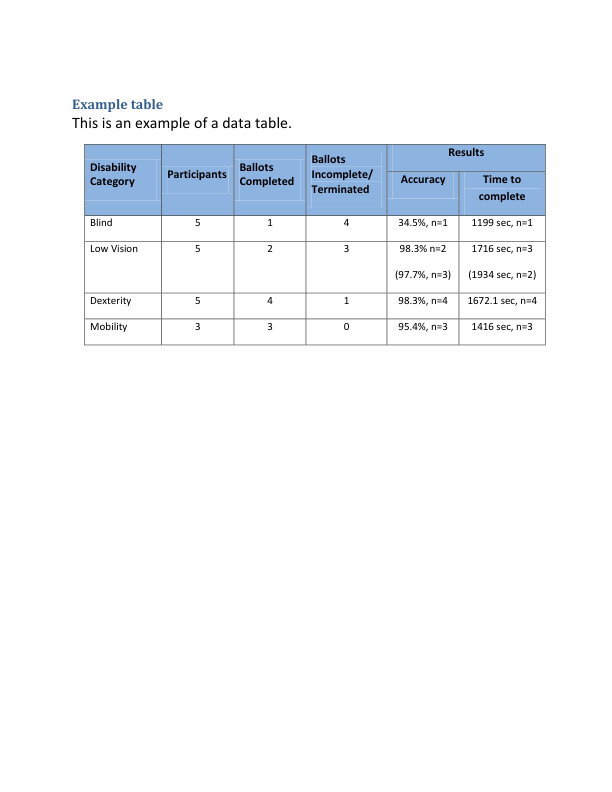

In [32]:
image

In [48]:
def rescale_bboxes(out_bbox, size):
    width, height = size
    boxes = box_cxcywh_to_xyxy(out_bbox)
    boxes = boxes * torch.tensor([width, height, width, height], dtype=torch.float32)
    return boxes

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def outputs_to_objects(outputs, img_size, id2label):

    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects


In [49]:
pixel_values = detection_transform(image).unsqueeze(0).to(device)

# forward pass
with torch.no_grad():
    outputs = structure_model(pixel_values)

outputs

TableTransformerObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[ -6.9798, -16.5006,   5.5330],
         [ -8.1427, -21.4375,   6.7938],
         [ -7.8082, -21.2275,   7.0279],
         [ -9.0152, -22.0214,   7.0139],
         [ -6.2457, -20.0832,   7.0470],
         [  4.7000, -12.9014,  -4.0342],
         [ -7.9704, -19.8499,   6.7462],
         [ -8.5140, -22.4037,   6.7789],
         [ -8.9756, -22.4659,   8.1864],
         [ -7.7421, -19.5232,   6.5866],
         [ -8.7823, -21.4975,   7.1976],
         [ -9.3328, -20.3233,   7.9727],
         [ -7.6823, -20.0144,   6.5440],
         [ -8.2404, -19.0343,   6.8171],
         [ -7.3673, -20.9662,   4.9636]]]), pred_boxes=tensor([[[0.5105, 0.3046, 0.7367, 0.2227],
         [0.8425, 0.4515, 0.2594, 0.1412],
         [0.5038, 0.2281, 0.7257, 0.1101],
         [0.1878, 0.3165, 0.2327, 0.1875],
         [0.5112, 0.0535, 0.7350, 0.0498],
         [0.5106, 0.3032, 0.7297, 0.2363],
         [0.5087, 0.3042, 0.7387, 0.2063]

In [50]:
id2label = structure_model.config.id2label
id2label[len(structure_model.config.id2label)] = "no object"
detected_tables = outputs_to_objects(outputs, image.size, id2label)

In [51]:
detected_tables

[{'label': 'table',
  'score': 0.9998390674591064,
  'bbox': [89.22334289550781,
   146.5525360107422,
   535.8013916015625,
   333.7051086425781]}]

In [53]:

draw = ImageDraw.Draw(image)

for detected_table in detected_tables:
    label = detected_table['label']
    score = detected_table['score']
    bbox = detected_table['bbox']
    
    x1, y1, x2, y2 = bbox
    
    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
    
    text = f"{label} ({score:.2f})"
    draw.text((x1, y1 - 10), text, fill="red")


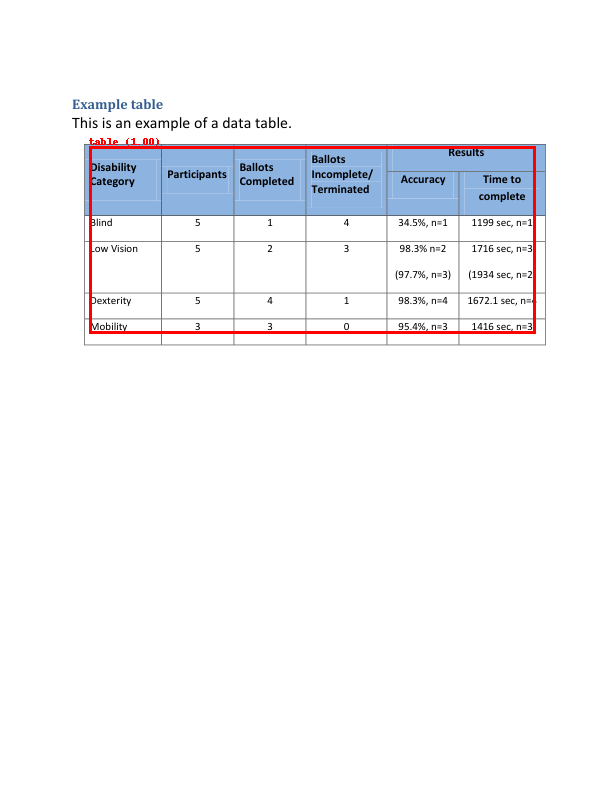

In [54]:
image

In [ ]:

https://deepinvent.ai/